In [ ]:
import sklearn
import pandas as pd
from sklearn.linear_model import LogisticRegression
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt


In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path = "/content/drive/MyDrive/SMLB/wildfire_train.csv"
raw_dataset = pd.read_csv(path)

Let's take a closer look at the data and try to figure out whether there are some redundant/irrelevant features.

In [ ]:
raw_dataset.head()

,Unnamed: 0,date,forest_area1,avg_dry_bulb_temperature,avg_dew_point,avg_relative_humidity,avg_rain_mm,avg_snow_cm,avg_hail_mm,avg_precipitation_mm,...,avg_ffmc,avg_dmc,avg_dc,avg_isi,avg_bui,avg_fwi,avg_edr,is_fire,is_fire_tmrw,is_fire_2days
0,87,1980-04-27,Edson,20.294118,1.058824,28.058824,0.000000,0.0,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
1,88,1980-05-16,Edson,19.588235,-1.882353,24.470588,0.047059,0.0,0.0,0.047059,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
2,89,1980-05-27,Edson,1.882353,1.705882,97.705882,12.276471,0.0,0.0,12.276471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
3,90,1980-05-30,Edson,4.411765,1.058824,80.882353,2.055294,0.0,0.0,2.055294,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
4,91,1980-06-21,Edson,16.647059,5.235294,48.588235,7.230588,0.0,0.0,7.230588,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107335 entries, 0 to 107334
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                107335 non-null  int64  
 1   date                      107334 non-null  object 
 2   forest_area1              107335 non-null  object 
 3   avg_dry_bulb_temperature  107334 non-null  float64
 4   avg_dew_point             107104 non-null  float64
 5   avg_relative_humidity     107115 non-null  float64
 6   avg_rain_mm               107334 non-null  float64
 7   avg_snow_cm               107334 non-null  float64
 8   avg_hail_mm               107334 non-null  float64
 9   avg_precipitation_mm      107334 non-null  float64
 10  avg_wind_speed_kmh        107334 non-null  float64
 11  avg_wind_gust_kmh         52021 non-null   float64
 12  avg_wind_azimuth          107334 non-null  float64
 13  avg_ffmc                  71433 non-null   f

It looks like there are several features with many missing values. If we simply drop columns or rows with missing values then we will be throwing a lot of information away. Will need to consider strategies for imputing these values.

The index feature should be irrelevant. Most features are numeric except for date and forest area. We will need to consider some sort of transformation of the date feature to capture seasonality information. Forest area is categorical so simplest approach is one-hot encoding, can also consider some sort of embedding scheme. Have to keep in mind that we may see new values for this category in the test set so have to handle that in some way (eg. all 0s in one hot, unknown embedding).

In [ ]:
raw_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,107335.0,70949.263707,38428.725738,87.0,38995.500000,72003.000000,104267.500000,135399.000000
avg_dry_bulb_temperature,107334.0,7.671756,11.061558,-41.4,1.462500,9.583333,16.000000,31.111111
avg_dew_point,107104.0,-0.130369,8.932782,-47.0,-5.090909,0.945455,6.625000,19.742857
avg_relative_humidity,107115.0,61.305791,18.942201,14.0,46.210526,59.315789,77.000000,100.000000
avg_rain_mm,107334.0,1.403090,3.499799,0.0,0.000000,0.121667,1.241847,112.111739
avg_snow_cm,107334.0,0.105023,0.718903,0.0,0.000000,0.000000,0.000000,29.191818
avg_hail_mm,107334.0,0.001688,0.030384,0.0,0.000000,0.000000,0.000000,2.333333
avg_precipitation_mm,107334.0,1.509801,3.644123,0.0,0.000000,0.136667,1.390848,112.295217
avg_wind_speed_kmh,107334.0,10.608897,5.115139,0.0,7.000000,9.892857,13.500000,51.500000
avg_wind_gust_kmh,52021.0,33.870932,9.600394,0.0,29.000000,34.000000,39.142857,291.000000


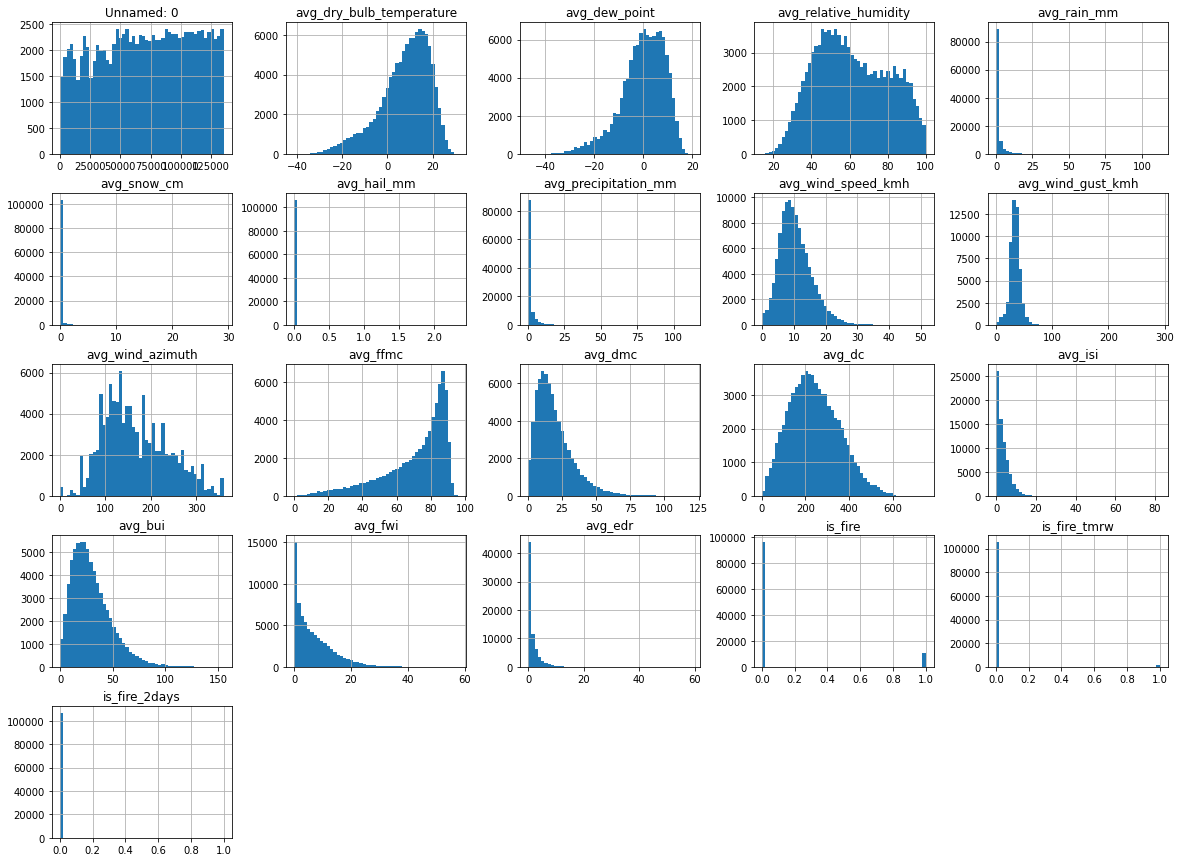

In [ ]:
raw_dataset.hist(bins=50, figsize=(20,15))
plt.show()

Looking at these histograms shows that some variables seem to follow power law distributions (e.g. avg_rain_mm) with most observations having small values but a few with extreme values. A quick google search shows that the maximum values seem plausible (heavy rainfall, snow storms, extreme wind gusts up on mountains) and natural phenomena can follow these types of distributions so I believe they are not outliers to be removed.

We can also see that the dataset is very imbalanced with many more days without fires than with fires. We will have to take this into consideration as well.

In [ ]:
raw_dataset.corr()

,Unnamed: 0,avg_dry_bulb_temperature,avg_dew_point,avg_relative_humidity,avg_rain_mm,avg_snow_cm,avg_hail_mm,avg_precipitation_mm,avg_wind_speed_kmh,avg_wind_gust_kmh,...,avg_ffmc,avg_dmc,avg_dc,avg_isi,avg_bui,avg_fwi,avg_edr,is_fire,is_fire_tmrw,is_fire_2days
Unnamed: 0,1.000000,-0.388526,-0.391896,0.113698,-0.138875,0.000425,-0.020592,-0.133463,-0.115755,-0.047784,...,0.009173,-0.089499,0.106909,-0.030275,-0.074138,-0.061131,-0.058776,-0.131632,-0.047293,-0.014995
avg_dry_bulb_temperature,-0.388526,1.000000,0.894866,-0.532267,0.098978,-0.091237,0.026287,0.077278,0.250645,0.144988,...,0.440745,0.345788,-0.057395,0.431672,0.332025,0.479135,0.395751,0.235877,0.077135,0.026239
avg_dew_point,-0.391896,0.894866,1.000000,-0.110170,0.269694,-0.024785,0.037149,0.254591,0.150181,0.091945,...,-0.097703,0.106029,-0.003175,-0.101057,0.116503,-0.017089,-0.016980,0.158909,0.051007,0.018489
avg_relative_humidity,0.113698,-0.532267,-0.110170,1.000000,0.314506,0.140397,0.010677,0.329470,-0.281311,-0.116715,...,-0.771731,-0.332415,0.065664,-0.681711,-0.306208,-0.648881,-0.518108,-0.213631,-0.071456,-0.021502
avg_rain_mm,-0.138875,0.098978,0.269694,0.314506,1.000000,0.099594,0.054906,0.980501,0.092961,0.085061,...,-0.674750,-0.214516,-0.167208,-0.342132,-0.223331,-0.330877,-0.224944,-0.039877,-0.015697,-0.005845
avg_snow_cm,0.000425,-0.091237,-0.024785,0.140397,0.099594,1.000000,0.010533,0.293015,0.008601,0.024840,...,-0.280005,-0.125081,-0.087841,-0.146538,-0.134988,-0.147785,-0.098753,-0.033977,-0.007028,-0.003260
avg_hail_mm,-0.020592,0.026287,0.037149,0.010677,0.054906,0.010533,1.000000,0.063147,0.004541,0.000333,...,-0.040064,-0.007713,-0.026823,-0.031694,-0.010173,-0.029061,-0.021359,0.019510,0.007232,-0.001846
avg_precipitation_mm,-0.133463,0.077278,0.254591,0.329470,0.980501,0.293015,0.063147,1.000000,0.091014,0.086186,...,-0.703955,-0.230947,-0.178276,-0.357951,-0.241407,-0.347372,-0.235829,-0.044838,-0.016401,-0.006272
avg_wind_speed_kmh,-0.115755,0.250645,0.150181,-0.281311,0.092961,0.008601,0.004541,0.091014,1.000000,0.717303,...,0.122304,0.077494,-0.030333,0.451838,0.068148,0.356017,0.365586,0.095816,0.028581,0.008760
avg_wind_gust_kmh,-0.047784,0.144988,0.091945,-0.116715,0.085061,0.024840,0.000333,0.086186,0.717303,1.000000,...,0.028264,0.070370,0.049913,0.289458,0.071990,0.225363,0.246525,0.042566,0.011494,0.000245


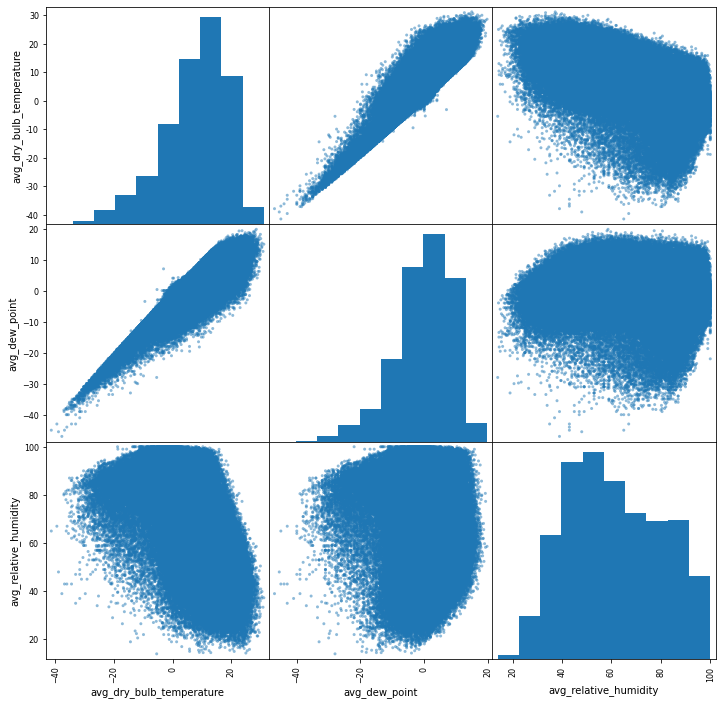

In [ ]:
from pandas.plotting import scatter_matrix

features_to_check = ["avg_dry_bulb_temperature", "avg_dew_point", "avg_relative_humidity"]

scatter_matrix(raw_dataset[features_to_check], figsize=(12,12))
plt.show()

Some of the features are very correlated and it seems that some are linear combinations of others so will have perfect multicollinearity. The precipitation is just the sum of rain, snow, and hail so should be removed. Wind speed and wind gusts are similar but not too too correlated. Dew point and dry bulb temperatures are super correlated and seem to be related by the humidity so could be some multicollinearity going on here. Also some of the features seem to be observations (e.g. temperature, humidity, wind, rain) that are somehow combined to get other features (ffmc, dmc, dc) that are further combined to get other features (isi, bui) and finally result in fwi. I'm not sure how these features are constructed, but seems to be a strong chance of multicollinearity.

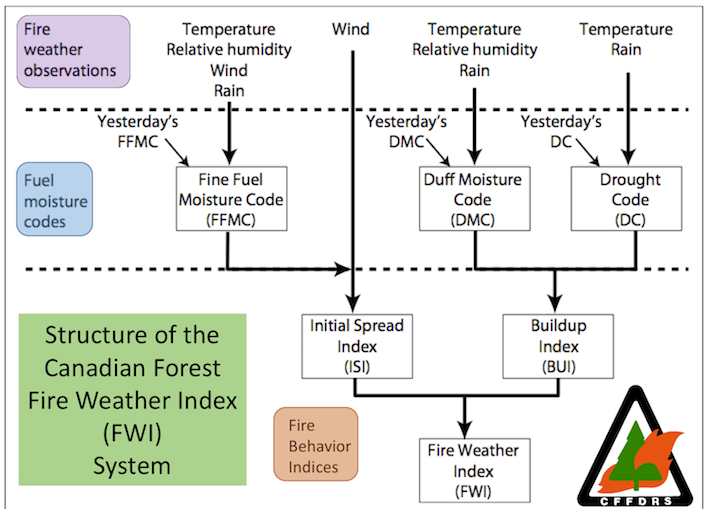

In [ ]:
precip_data = raw_dataset[["avg_rain_mm", "avg_snow_cm", "avg_hail_mm", "avg_precipitation_mm"]]
precip_data = precip_data.dropna()

In [ ]:
precip_data["calculated_precipitation"] = precip_data["avg_rain_mm"] + precip_data["avg_hail_mm"] + precip_data["avg_snow_cm"]

In [ ]:
precip_data.head()

,avg_rain_mm,avg_snow_cm,avg_hail_mm,avg_precipitation_mm,calculated_precipitation
0,0.000000,0.0,0.0,0.000000,0.000000
1,0.047059,0.0,0.0,0.047059,0.047059
2,12.276471,0.0,0.0,12.276471,12.276471
3,2.055294,0.0,0.0,2.055294,2.055294
4,7.230588,0.0,0.0,7.230588,7.230588


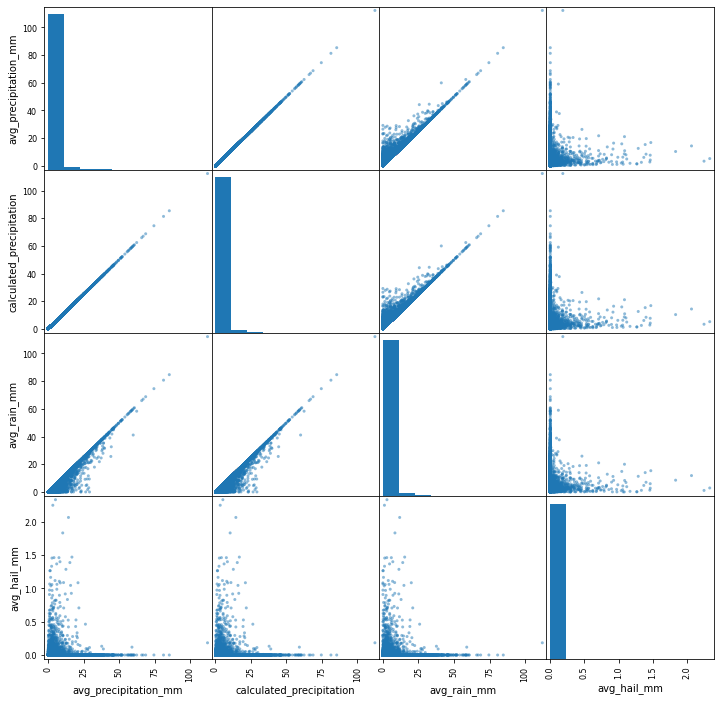

In [ ]:
scatter_matrix(precip_data[["avg_precipitation_mm", "calculated_precipitation", "avg_rain_mm", "avg_hail_mm"]], figsize=(12,12))
plt.show()

The avg precipitation doesn't seem to be just the sum of the values for snow, hail and rain. Not sure exactly what is going on. Will try to fit a linear regression and examine the coefficients.

In [ ]:
from sklearn.linear_model import LinearRegression

precip_data = raw_dataset[["avg_rain_mm", "avg_snow_cm", "avg_hail_mm", "avg_precipitation_mm"]]
X = precip_data.dropna()
y = X.pop("avg_precipitation_mm")

In [ ]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [ ]:
print(model.coef_)
print(model.intercept_)

[1. 1. 1.]
-1.8107737531636303e-12


Okay so that helped because it seems the precipitation in mm is the sum of rain in mm, hail in mm, and snow in cm. So converting from cm to mm for snow was throwing the correlations off. Not sure whether this was a mistake in labelling the feature or what, but now we know for certain that precipitation is just a linear combination of rain, hail, and snow.

Let's try the same thing with dew point, dry bulb temp, and humidity to try to find their relationship.

In [ ]:
temp_data = raw_dataset[["avg_dry_bulb_temperature", "avg_dew_point", "avg_relative_humidity"]]

In [ ]:
X = temp_data.dropna()
y = X.pop("avg_dew_point")

In [ ]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [ ]:
print(model.coef_)
print(model.intercept_)

[0.94285031 0.24096767]
-22.163177193082287


In [ ]:
model.score(X, y)

0.9879217679535958

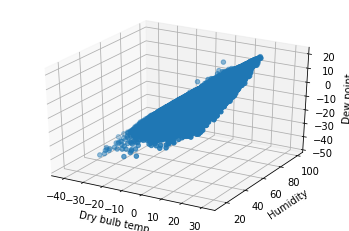

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(X["avg_dry_bulb_temperature"], X["avg_relative_humidity"], y)
ax.set_xlabel("Dry bulb temp")
ax.set_ylabel("Humidity")
ax.set_zlabel("Dew point")
plt.show()

So it doesn't look like perfect multicollinearity, but very close to it. Perhaps just measurement error that adds a bit of noise to relationship. So probably should take out one feature, but will experiment to be certain that improves performance. Also note that it seems temperature (presumably dry bulb?) and humidity are factors in ffm so seems like dew point temp redundant.

Now let's look at the index features that are combinations of raw observational features.

In [ ]:
ffmc_data = raw_dataset[["avg_dry_bulb_temperature", "avg_relative_humidity", "avg_wind_speed_kmh",
                         "avg_rain_mm", "avg_ffmc"]]


In [ ]:
X = ffmc_data.dropna()
y = X.pop("avg_ffmc")

In [ ]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [ ]:
print(model.coef_)
print(model.intercept_)

[ 0.37827668 -0.50257179  0.19991173 -2.04632318]
97.30469210110782


In [ ]:
model.score(X, y)

0.7366410035365812

In [ ]:
dmc_data = raw_dataset[["avg_dry_bulb_temperature", "avg_relative_humidity",
                         "avg_rain_mm", "avg_dmc"]]


In [ ]:
X = dmc_data.dropna()
y = X.pop("avg_dmc")

In [ ]:
model = LinearRegression()
model.fit(X, y)

print(model.coef_)
print(model.intercept_)
print(model.score(X, y))

[ 0.51161182 -0.10893279 -0.41164409]
20.00517894911115
0.16167278357208648


In [ ]:
dc_data = raw_dataset[["avg_dry_bulb_temperature",
                         "avg_rain_mm", "avg_dc"]]

In [ ]:
X = dc_data.dropna()
y = X.pop("avg_dc")

In [ ]:
model = LinearRegression()
model.fit(X, y)

print(model.coef_)
print(model.intercept_)
print(model.score(X, y))

[-1.25789448 -5.02899659]
267.7760066959941
0.03372511111743448


In [ ]:
isi_data = raw_dataset[["avg_ffmc", "avg_wind_speed_kmh",
                         "avg_isi"]]

In [ ]:
X = isi_data.dropna()
y = X.pop("avg_isi")

model = LinearRegression()
model.fit(X, y)

print(model.coef_)
print(model.intercept_)
print(model.score(X, y))

[0.11138231 0.25021998]
-7.2984655966429
0.601202554032759


In [ ]:
bui_data = raw_dataset[["avg_dmc", "avg_dc",
                         "avg_bui"]]

X = bui_data.dropna()
y = X.pop("avg_bui")

model = LinearRegression()
model.fit(X, y)

print(model.coef_)
print(model.intercept_)
print(model.score(X, y))

[1.256412   0.02740819]
-1.1494531725233834
0.982923330119033


In [ ]:
fwi_data = raw_dataset[["avg_isi", "avg_bui",
                         "avg_fwi"]]

X = fwi_data.dropna()
y = X.pop("avg_fwi")

model = LinearRegression()
model.fit(X, y)

print(model.coef_)
print(model.intercept_)
print(model.score(X, y))

[1.57144468 0.13199898]
-2.4397588349389716
0.9590782359479946


So it looks like FWI and BUI are close to being simple linear combinations of their inputs, so are strong candidates for removal. FFMC, DMC, DC, and ISI look like a bit more involved that a linear combination of inputs but will still experiment with their removal as possibility of multicollinearity exists.

So after exploring the data we have the following conclusions:

- transform dates to get seasonality information (also think about ways to include time information beyond season as fire risk may have increased due to global warming, but maybe this is all captured in other features anyway)
- transform wind angle to vector
- categorical features for forest area, need to handle unknown values since there may be new areas in test data
- remove precipitaion as it is simply sum of rain, snow, hail
- remove dew point and it is linear combination of dry bulb temp and humidity
- consider index features (ffmc, dmc, dc, isi and especially bui and fwi) for removal as they are derived from observations such as temperature. May want to keep them, though, if they contain some expert knowledge our model will have trouble learning from the data. So experimentation needed to determine which to keep.
- might want to get rid of wind gust feature as it is absent in half the records and seems correlated with wind speed (although not perfectly so there could be some useful information there)

Another concern is the class imbalance for the predictions. Will need to compensate for this, perhaps with class weights in the training loss.